# Initial data exploration and structure

The purpose of this notebook is to explore and understand the structure and content of the Job Descriptions 2025 dataset.

**Main points**

* Assess the quality and completeness of the dataset.
* Examine the distribution of job categories (Tech vs. Non-Tech).
* Analyze the overall characteristics of the job descriptions, such as text length, vocabulary diversity, and common terms.
* Identify potential issues or insights that will guide the next steps in text preprocessing and NLP modeling.

# ⚙️ Configuration

In [1]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import spacy

c:\Users\arual\Desktop\projects\Job_Descriptions_2025_NPL\envjob\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ♻️ Import data

The information is stored in a json file. We download the files and open the json one.

In [2]:
# Download data from Kaggle
path = kagglehub.dataset_download("adityarajsrv/job-descriptions-2025-tech-and-non-tech-roles")

# Save in this repository
df_raw = pd.read_json(os.path.join(path, "job_dataset.json"))

In [3]:
df_raw.head(20)


,JobID,Title,ExperienceLevel,YearsOfExperience,Skills,Responsibilities,Keywords
0,NET-F-001,.NET Developer,Fresher,0-1,"[C#, VB.NET basics, .NET Framework, .NET Core ...","[Assist in coding and debugging applications, ...","[.NET, C#, ASP.NET MVC, Entity Framework, SQL ..."
1,NET-F-002,.NET Developer,Fresher,0-1,"[C#, .NET Framework basics, ASP.NET, Razor, HT...","[Write simple C# programs under guidance, Supp...","[.NET, C#, ASP.NET MVC, Entity Framework, SQL ..."
2,NET-F-003,.NET Developer,Fresher,0-1,"[C#, VB.NET basics, .NET Core, ASP.NET MVC, HT...","[Contribute to development of small modules, A...","[.NET, C#, ASP.NET MVC, SQL Server, Entity Fra..."
3,NET-F-004,.NET Developer,Fresher,0-1,"[C#, .NET Framework, ASP.NET basics, SQL Serve...","[Support in software design documentation, Ass...","[.NET, C#, SQL Server, Entity Framework, ASP.NET]"
4,NET-F-005,.NET Developer,Fresher,0-1,"[C#, ASP.NET, MVC, Entity Framework basics, SQ...",[Learn to design and build ASP.NET application...,"[.NET, C#, ASP.NET MVC, Entity Framework, SQL ..."
5,NET-F-006,.NET Developer,Fresher,0-1,"[C#, .NET Framework, ASP.NET, Razor, SQL Serve...","[Assist in Razor page development, Learn versi...","[.NET, C#, ASP.NET, Razor, SQL Server, Unit Te..."
6,NET-F-007,.NET Developer,Fresher,0-1,"[C#, VB.NET, .NET Core basics, ASP.NET MVC, HT...","[Support team in MVC project development, Help...","[.NET, C#, ASP.NET MVC, SQL Server]"
7,NET-F-008,.NET Developer,Fresher,0-1,"[C#, .NET Framework basics, ASP.NET MVC, Entit...","[Assist in building backend modules, Learn and...","[.NET, C#, ASP.NET MVC, Entity Framework, LINQ..."
8,NET-F-009,.NET Developer,Fresher,0-1,"[C#, .NET Framework, ASP.NET, HTML, CSS, SQL S...","[Write simple ASP.NET pages, Collaborate with ...","[.NET, C#, ASP.NET, SQL Server]"
9,NET-F-010,.NET Developer,Fresher,0-1,"[C#, ASP.NET MVC, .NET Core basics, Entity Fra...","[Support new feature development, Assist with ...","[.NET, C#, ASP.NET MVC, Entity Framework, SQL ..."


# Cleaning function

Most of the features are textual. Work with this kind of information requiers always a previous cleaning process. Before start with any analyse, we are going to create function to clean text. Preparing this first allows us to work more efficiently.

This is a generic function. We will enrich it depending on the feature.

In [4]:
# Load the model (medium size model)
nlp = spacy.load("en_core_web_sm") # python -m spacy download en_core_web_sm

# Cleaning function
def clean_text(text):
    # Convert anything to string first
    text = str(text).lower()
    # Lowercase
    text = text.lower()
    # Replace slashes with space
    text = text.replace("/", " ")    
    # Remove unwanted special characters (keep + and #)
    text = re.sub(r"[^a-z+#\s]", " ", text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Lemmatization
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc if not token.is_stop])
    return lemmatized_text

# 🔍 Data Exploration (EDA)

Now were are going to performe an EDA at table level. In the the fild `03_eda_language.ipynb` we will performe a more specific EDA, focus in the linguistic analyse.

## General information

We will take a look in the data structure: shape, nulls, duplacated

In [5]:
print(f"Rows: {df_raw.shape[0]:,} | Columns: {df_raw.shape[1]}")

Rows: 1,068 | Columns: 7


In [6]:
df_raw.sample(n=5, random_state=1)

,JobID,Title,ExperienceLevel,YearsOfExperience,Skills,Responsibilities,Keywords
457,13,Full Stack Developer - Experienced,Experienced,3–5 years,"[HTML5, CSS3, JavaScript, React, Angular, Vue....",[Develop and maintain full-stack applications ...,"[Full Stack Developer, Experienced, Mid-Level,..."
347,DS-F8,Fresher Data Scientist,Fresher,0-1,"[Python, R, SQL, Pandas, NumPy, Matplotlib, Se...","[Analyze small datasets to extract insights, B...","[Data Scientist, Python, R, SQL, Machine Learn..."
639,NE009,Network Intern,Fresher,0,"[DHCP, Subnetting, Cisco IOS, VPN Basics]","[Assist senior engineers on projects, Help con...","[Internship, Cisco IOS, Subnetting, DHCP]"
833,SRE-F-003,Site Reliability Engineer,Fresher,0-1,"[Python basics, Bash scripting basics, Linux a...","[Assist in setting up monitoring dashboards, S...","[Python, Bash, Linux, Docker, Kubernetes, AWS,..."
437,FE011,Frontend Developer - Experienced,Mid-Senior Level,3–6 years,"[HTML5, CSS3, JavaScript (ES6+), React/Redux, ...",[Design and develop advanced frontend applicat...,"[Frontend, Web Application Development, Mid-Se..."


In [7]:
df_raw.isnull().sum().sort_values(ascending=False)

Title                1
JobID                0
ExperienceLevel      0
YearsOfExperience    0
Skills               0
Responsibilities     0
Keywords             0
dtype: int64

In [8]:
# Duplicated only in the principal columns
duplicates = df_raw.duplicated(subset=(["Title", "JobID"])).sum()

print(f"Duplicated rows: {duplicates}")

Duplicated rows: 0


### 🧠 General infomation - Conclusions

* We are working with 1.068 registers with information in seven columns.
* Only one job has no information about Title. The other features are compleate.
* No duplicated rows (Title and JobId) were detected.

The structure of the data is solid to build any model.

## Catgorical distribution

We are going to explore the count in each level for the categorical variables: ExperienceLevel, YearsOfExperience, Skills, Keywords

### Experience level

There are some equivalent categories. The idea is group them into few labels. As there are few labels we will do it using a dictionarie.

In [9]:
print(f'Original labels: {df_raw["ExperienceLevel"].unique()}')

Original labels: ['Fresher' 'Experienced' 'Entry-Level' 'Mid-Senior Level' 'Senior-Level'
 'Mid-Level' 'Mid-Senior' 'Senior' 'Junior' 'Mid-level' 'Lead']


In [10]:
# Group different labels. 
mapping = {
    "Fresher": "Entry",
    "Entry-Level": "Entry",
    "Junior": "Entry",

    "Mid-Level": "Mid",
    "Mid-level": "Mid",

    "Mid-Senior Level": "Mid-Senior",
    "Mid-Senior": "Mid-Senior",

    "Experienced": "Senior",
    "Senior-Level": "Senior",
    "Senior": "Senior",
    "Lead": "Senior",   
}

# Create a new column
df_raw["ExperienceLevel_clean"] = (
    df_raw["ExperienceLevel"]
    .str.strip()
    .replace(mapping)
    .fillna("Other")
)

# Result
print(f'Final labels: {df_raw["ExperienceLevel_clean"].unique()}')

Final labels: ['Entry' 'Senior' 'Mid-Senior' 'Mid']


C:\Users\arual\AppData\Local\Temp\ipykernel_6940\439561191.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


Text(0, 0.5, 'Experience Level')

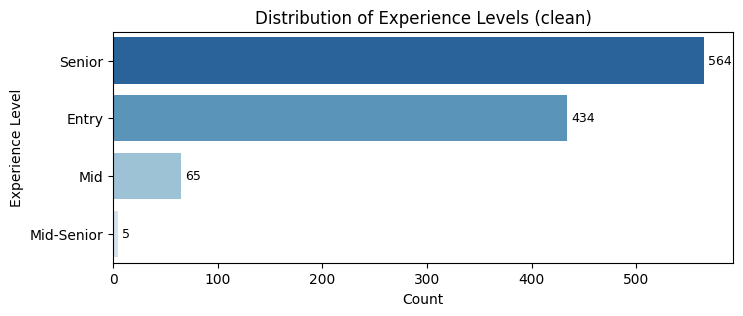

In [11]:
# Plot

fig, ax = plt.subplots(figsize=(8, 3))

sns.countplot(
    y="ExperienceLevel_clean",
    data=df_raw,
    order=df_raw["ExperienceLevel_clean"].value_counts().index,
    ax=ax,
    palette="Blues_r"
)

# Add counts on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3, fontsize=9, color='black')

ax.set_title("Distribution of Experience Levels (clean)")
ax.set_xlabel("Count")
ax.set_ylabel("Experience Level")

### Years Of Experience

The codification of this column is very mixed. As it is related with the level, we are going to explore both variables together in order to make a cetegorization

In [12]:
exp_summary = (
    df_raw
    .groupby(["ExperienceLevel_clean", "YearsOfExperience"])
    .size()
    .reset_index(name="Count")
    .sort_values(by=["ExperienceLevel_clean", "YearsOfExperience"])
)

exp_summary

,ExperienceLevel_clean,YearsOfExperience,Count
0,Entry,0,48
1,Entry,0-1,247
2,Entry,0-1 Years,10
3,Entry,0-2,25
4,Entry,0–1 year,104
...,...,...,...
112,Senior,8–10 years,1
113,Senior,9,2
114,Senior,9+,8
115,Senior,9-12,3


In [13]:
# Clean the feature selecting only the number. If it's a range, we only mantain the first number of the interval.

df_raw["YearsOfExperience_num"] = (df_raw["YearsOfExperience"].astype(str).str.extract(r'(\d+)')[0].astype("Int64")
)
# Check if nulls
print("Nulls:", df_raw["YearsOfExperience_num"].isna().sum())

# Comparation
df_raw[["YearsOfExperience", "YearsOfExperience_num"]]

Nulls: 0


,YearsOfExperience,YearsOfExperience_num
0,0-1,0
1,0-1,0
2,0-1,0
3,0-1,0
4,0-1,0
...,...,...
1063,5+,5
1064,4+,4
1065,5+,5
1066,4+,4


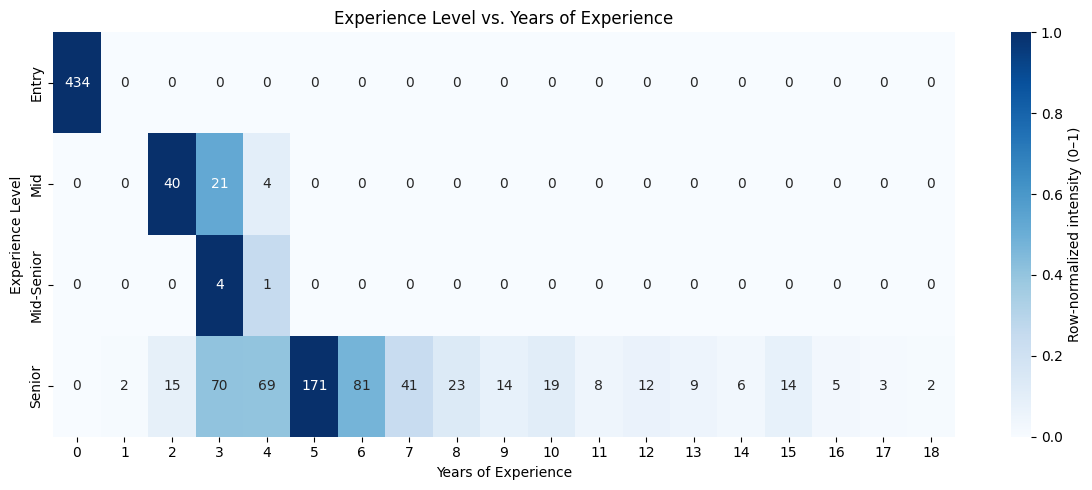

In [14]:
# Explore the relationship between ExperienceLevel_clean and YearsOfExperience

## a. Summary YearsOfExperience_num, ExperienceLevel_clean, Count
year_summary = (
    df_raw.dropna(subset=["ExperienceLevel_clean", "YearsOfExperience_num"])
          .groupby(["ExperienceLevel_clean", "YearsOfExperience_num"])
          .size()
          .reset_index(name="Count")
)
ys = year_summary.dropna(subset=["YearsOfExperience_num", "ExperienceLevel_clean"]).copy()
ys["YearsOfExperience_num"] = ys["YearsOfExperience_num"].astype(int)

# # Pivot and sort by years
pivot_counts = (
    ys.pivot(index="ExperienceLevel_clean", columns="YearsOfExperience_num", values="Count")
      .fillna(0)
      .reindex(sorted(ys["YearsOfExperience_num"].unique()), axis=1)
)

# Normalization: for each row we scale by it maximun (it's only for present the color scale by row)
pivot_norm = pivot_counts.div(pivot_counts.max(axis=1).replace(0, np.nan), axis=0).fillna(0)

# Plot
plt.figure(figsize=(12, 5))

sns.heatmap(
    pivot_norm, cmap="Blues", vmin=0, vmax=1,
    annot=pivot_counts.astype(int), fmt="d",
    cbar_kws={"label": "Row-normalized intensity (0–1)"}
)
plt.title("Experience Level vs. Years of Experience")
plt.xlabel("Years of Experience")
plt.ylabel("Experience Level")
plt.tight_layout()
plt.show()


In [15]:
# Group Mid and Mid-Senior (rewritting ExperienceLevel_clean values)
df_raw["ExperienceLevel_clean"] = (
    df_raw["ExperienceLevel_clean"]
    .replace({"Mid-Senior": "Mid"})
)

# Print final labels
print(f'Final labels: {df_raw["ExperienceLevel_clean"].unique()}')

Final labels: ['Entry' 'Senior' 'Mid']


## Text features

Now we are going to explore the textual features.

First of all, we display the lenght of each category and an example of each one.

In [16]:
print("Title:")
print(f'Minimum length is {df_raw["Title"].str.len().min()} and maximum length is {df_raw["Title"].str.len().max()} with an average of {df_raw["Title"].str.len().mean():.2f} characters.')
print(f'example: {df_raw["Title"].iloc[42]}\n')

print("Skills:")
print(f'Minimum length is {df_raw["Skills"].str.len().min()} and maximum length is {df_raw["Skills"].str.len().max()} with an average of {df_raw["Skills"].str.len().mean():.2f} skills.')
print(f'example: {df_raw["Skills"].iloc[42]}\n')

print("Responsibilities:")
print(f'Minimum length is {df_raw["Responsibilities"].str.len().min()} and maximum length is {df_raw["Responsibilities"].str.len().max()} with an average of {df_raw["Responsibilities"].str.len().mean():.2f} responsibilities.')
print(f'example: {df_raw["Responsibilities"].iloc[42]}\n')

Title:
Minimum length is 9.0 and maximum length is 40.0 with an average of 20.06 characters.
example: AI Prompt Engineer

Skills:
Minimum length is 4 and maximum length is 27 with an average of 11.47 skills.
example: ['Python basics', 'JavaScript basics', 'Intro to NLP', 'Hugging Face basics', 'SpaCy basics', 'NLTK basics', 'Prompt writing fundamentals', 'OpenAI GPT models exposure', 'TensorFlow basics', 'PyTorch basics', 'Critical thinking', 'Communication', 'Collaboration', 'Creativity']

Responsibilities:
Minimum length is 2 and maximum length is 13 with an average of 6.21 responsibilities.
example: ['Assist in prompt design for AI models', 'Evaluate prompt outcomes', 'Support AI/data science team tasks', 'Document experiments', 'Learn NLP libraries', 'Assist in integration of prompts into AI applications']



### Title

Title refers to the main description of the job.

The table bellow shows a first aproximation to the feature. If we compare the most and less common titles we see that there is more demand of technical roles while user-experience roles have less vacancies. 

In [17]:
print(df_raw["Title"].describe())
print("...........................")
print("10 most common titles:")
print(df_raw["Title"].nunique(), df_raw["Title"].value_counts().head(10))
print("...........................")
print("10 less common titles:")
print(df_raw["Title"].nunique(), df_raw["Title"].value_counts().tail(10))


count               1067
unique               218
top       .NET Developer
freq                  20
Name: Title, dtype: object
...........................
10 most common titles:
218 Title
.NET Developer          20
AI Prompt Engineer      20
AR/VR Developer         20
Business Analyst        20
Data Engineer           20
Content Writer          20
Copywriter              20
Big Data Specialist     20
Blockchain Developer    20
Product Manager         20
Name: count, dtype: int64
...........................
10 less common titles:
218 Title
UX Trainee Designer            1
UX Design Intern               1
UX Architect                   1
Principal UX Designer          1
UX Manager                     1
Senior Interaction Designer    1
UX Consultant                  1
UX Strategist                  1
UX Design Lead                 1
Staff UX Designer              1
Name: count, dtype: int64


The results that we found are made we the raw title. We need to clean it first.

A quick glance on our data shows that some titles include infromation about the experience (entry level, specialist, etc). We will remove that information from the Title but creating a new column. We will use that information to compare with the informed experience column.

**Step summary**:

* Clean title.
* Extract experience word and clean in the same way.
* Create a column that stores title experience information.
* Remove experience from title clean column.

In [27]:
# 1. Cleaning function in title column
df_raw["Title_clean"] = df_raw["Title"].apply(clean_text)

# 2. Experience level patterns to remove. 

## Expirience patterns detected
experience = [
    "entry level", "junior", "jr", "mid level", "middle", "semi senior", "fresher",
    "experienced", "senior", "sr", "specialist", "lead", "principal",
    "head", "manager", "director", "expert", "intern", "graduate", "trainee"
]

## Clean the patterns (same preprocessing)
experience_clean = [clean_text(e) for e in experience]

# Build flexible regex (allow space, hyphen, or slash)
exp_regex = re.compile(
    r"\b(" + "|".join(
        [p.replace(" ", r"[\s\-\/]?") for p in experience_clean]
    ) + r")\b",
    re.IGNORECASE
)

# 3. New column with the experience level found in the title
df_raw["ExperienceLevel_title"] = (
    df_raw["Title_clean"]
    .apply(lambda x: ", ".join(sorted(set(m)) ) if (m := exp_regex.findall(str(x).lower())) else "")
)

# 4. Remove experience level from the clean title
df_raw["Title_clean"] = (
    df_raw["Title_clean"]
    .str.replace(exp_regex, " ", regex=True)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

# Check results
df_raw[["Title", "Title_clean", "ExperienceLevel_title"]].drop_duplicates()

,Title,Title_clean,ExperienceLevel_title
0,.NET Developer,net developer,
20,AI Engineer - Fresher,ai engineer,fresher
29,AI Engineer - Experienced,ai engineer,experience
36,NaN,nan,
40,AI Prompt Engineer,ai prompt engineer,
...,...,...,...
1025,UX Consultant,ux consultant,
1026,Staff UX Designer,staff ux designer,
1027,UX Design Lead,ux design,lead
1028,Vibe Coder,vibe coder,
